In [1]:
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import utils
import gb_utils


% matplotlib inline


### Колонки с пропусками
Все эти колонки описывают моменты, которые могли не произойти в первые 5 минут игры.

In [2]:
train_data = utils.get_data(fillna=False)
test_data = utils.get_data(test=True, sample=False)
X_train = train_data.loc[:, train_data.columns != 'radiant_win']
gb_utils.get_skips_df(train_data)

,skips_count
first_blood_time,9826
first_blood_team,9826
first_blood_player1,9826
first_blood_player2,22098
radiant_bottle_time,7841
radiant_courier_time,327
radiant_flying_courier_time,13702
radiant_first_ward_time,906
dire_bottle_time,8181
dire_courier_time,330


### Подготовка данных
В процессе обучения классификатора, я выяснил, что использование среднего значения данных о каждом игроке(золото, опыт и тп.) значительно ускоряет время обучения, а также повышает качество классификации на 5-7%. Однако колонку, содержащую информацию о герое преобразовывать таким способом не имеет смысла, поэтому я прибегнул к методу мешка слов. А также на этом шаге я заменил все nan значения на 0 и удалил колонки, не представляющие никакой важности.

In [4]:
X_train = utils.replace_with_bag_of_words(utils.prepare_data(X_train.fillna(0)))
X_train.head()

,first_blood_team,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
7268,0.0,140.0,-82.0,0.0,1,3,2,0,-15.0,297.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102573,1.0,115.0,-80.0,0.0,3,2,2,0,-33.0,79.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
91276,0.0,67.0,-87.0,196.0,4,3,2,1,-50.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96117,0.0,0.0,-80.0,0.0,2,4,1,0,208.0,128.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
77335,0.0,98.0,-81.0,210.0,1,5,2,1,26.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Извлекаем целевую переменную

In [5]:
y = train_data['radiant_win']
y

match_id
7268      1
102573    1
91276     0
96117     1
77335     1
40427     1
11959     0
42085     0
63967     1
56698     1
48931     1
38178     0
15922     1
30487     1
72279     0
81778     1
285       1
51505     1
100355    0
7794      1
6975      1
9489      1
7518      1
80148     1
110380    1
30261     0
54933     0
50197     1
8942      1
91457     1
         ..
14481     0
73756     1
86057     1
63174     1
54695     0
29523     0
36986     0
111922    0
94075     0
27409     1
97150     1
96737     0
34861     1
60531     0
50163     1
33650     1
41755     0
72731     0
86864     0
7523      1
99645     1
2155      1
41852     1
103428    1
75881     0
78090     1
93622     1
48420     1
104177    1
107070    0
Name: radiant_win, Length: 48615, dtype: int64

Обучаем классификатор, используя разные значения для количества деревьев(n_estimators) проводя кросс-валидацию по 5 блокам для оценки качества.

In [6]:
estimators = [10, 20, 30, 70, 120, 250]
scores = []
cross_val_times = []
for n_estimators in estimators:
    cv = KFold(n_splits=5, shuffle=True, random_state=241)
    clf = GradientBoostingClassifier(n_estimators=n_estimators, random_state=241)
    start_time = datetime.now()
    score = cross_val_score(estimator=clf, cv=cv, X=X_train, y=y, scoring='roc_auc').mean()
    cross_val_times.append(datetime.now() - start_time)
    scores.append(score)

Время, которое заняла кросс-валидация по 5 блокам для 30 деревьев:

In [7]:
cross_val_times[estimators.index(30)].total_seconds()

26.276127

Ниже представлен график, показывающий изменение качества классификации с повышением количества деревьев

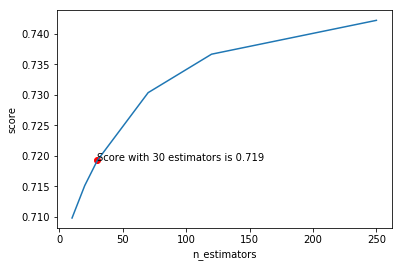

In [8]:
gb_utils.plot(estimators, scores)

Исходя из данных графика, можно заметить, что использование большего количества деревьев влечет за собой повышение качества, а следовательно - есть смысл использовать больше чем 30 деревьев.